# Model training

## Cross-sectional data

In [1]:
import numpy as np
import pandas as pd
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.rocket import MiniRocket, MiniRocketMultivariate
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.datasets import load_from_arff_to_dataframe
from sktime.classification.interval_based import (
    CanonicalIntervalForest,
    DrCIF,
    RandomIntervalSpectralEnsemble,
    SupervisedTimeSeriesForest,
    TimeSeriesForestClassifier,
)
from sktime.classification.kernel_based import Arsenal
from sktime.datatypes._panel._convert import from_multi_index_to_3d_numpy
from sktime.datasets import load_from_tsfile
from tsfresh.utilities.dataframe_functions import roll_time_series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.datasets import make_multilabel_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score
from mcfly.find_architecture import find_best_architecture
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import warnings

warnings.simplefilter('ignore')

SEED=42

%matplotlib inline

2022-06-25 14:17:29.537606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-25 14:17:29.537969: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv("../data/odb-2-master-thesis/exp1_14drivers_14cars_dailyRoutes_interpolated.csv")
df.head()

,AIR_INTAKE_TEMP,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,SHORT TERM FUEL TRIM BANK 1,SPEED,THROTTLE_POS,TIMING_ADVANCE,TROUBLE_CODES,VEHICLE_ID,TIMESTAMP,TROUBLE_CODES_BINARY
0,59.0,80.0,0.333,1009.0,0.0,0.0,0.251,0.569,NaN,car1,2017-08-16 16:55:04.267,0
1,59.0,80.0,0.325,1003.0,0.0,0.0,0.251,0.565,NaN,car1,2017-08-16 16:55:12.283,0
2,59.0,80.0,0.329,995.0,0.0,0.0,0.251,0.573,NaN,car1,2017-08-16 16:55:20.291,0
3,60.0,80.0,0.325,1004.0,0.0,0.0,0.251,0.565,NaN,car1,2017-08-16 16:55:28.300,0
4,60.0,80.0,0.329,1005.0,0.0,0.0,0.251,0.569,NaN,car1,2017-08-16 16:55:36.320,0


In [44]:
df[df["TROUBLE_CODES"] == "P0133"]["VEHICLE_ID"].unique()

array(['car6'], dtype=object)

In [45]:
df[df["TROUBLE_CODES"] == "C0300"]["VEHICLE_ID"].unique()

array(['car9'], dtype=object)

In [5]:
df["TROUBLE_CODES"].unique()

array([nan, 'P0133', 'C0300', 'P0079P2004P3000', 'P0078U1004P3000',
       'P0079C1004P3000', 'P007EP2036P18F0', 'P007EP2036P18D0',
       'P007FP2036P18D0', 'P0079P1004P3000', 'P007EP2036P18E0',
       'P007FP2036P18E0', 'P0078B0004P3000', 'P007FP2036P18F0'],
      dtype=object)

In [10]:
df["TROUBLE_CODES"].value_counts()

P0133              6070
C0300              5673
P0079P2004P3000      48
P0079C1004P3000      30
P0078U1004P3000      29
P007EP2036P18D0      20
P007EP2036P18E0      18
P0078B0004P3000      12
P007EP2036P18F0       9
P0079P1004P3000       5
P007FP2036P18E0       5
P007FP2036P18D0       3
P007FP2036P18F0       3
Name: TROUBLE_CODES, dtype: int64

Generic DTC description:


* P0133 
    * Oxygen Sensor Circuit Slow Response ([Source](https://www.autozone.com/diy/diagnostic-trouble-codes/what-p0133-means-and-how-to-fix-it))
* C0300 
    * Rear propshaft signal circuit malfunction ([Source](https://obdii.pro/de/code/C0300))
* P007F 
    * Charge Air Cooler Temperature Sensor Bank1/Bank2 Correlation ([Source](http://www.dtcsearch.com/P007F/))
* P007E 
    * Charge Air Cooler Temperature Sensor Circuit Intermittent/Erratic ([Source](http://www.dtcsearch.com/P007E/))
* P0078 
    * Exhaust Valve Control Solenoid Circuit ([Source](http://www.dtcsearch.com/P0078/))
* P0079 
    * Exhaust Valve Control Solenoid Circuit Low ([Source](http://www.dtcsearch.com/P0079/))

In [72]:
result = {
    "P0079": 0,
    "P0078": 0,
    "P007E": 0,
    "P007F": 0
}

counts = df["TROUBLE_CODES"].value_counts()

for k in result.keys():
    for m in counts.keys():
        if k in m:
            result[k] += counts[m]

result

{'P0079': 83, 'P0078': 41, 'P007E': 47, 'P007F': 11}

In [19]:
df["TARGET P0133"] = np.where(df["TROUBLE_CODES"] == "P0133", 1, 0)
df["TARGET C0300"] = np.where(df["TROUBLE_CODES"] == "C0300", 1, 0)

In [35]:
selected_columns = df.columns.difference(["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP", "TROUBLE_CODES_BINARY"])
df[selected_columns].head()

,AIR_INTAKE_TEMP,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,SHORT TERM FUEL TRIM BANK 1,SPEED,TARGET C0300,TARGET P0133,THROTTLE_POS,TIMING_ADVANCE
0,59.0,80.0,0.333,1009.0,0.0,0.0,0,0,0.251,0.569
1,59.0,80.0,0.325,1003.0,0.0,0.0,0,0,0.251,0.565
2,59.0,80.0,0.329,995.0,0.0,0.0,0,0,0.251,0.573
3,60.0,80.0,0.325,1004.0,0.0,0.0,0,0,0.251,0.565
4,60.0,80.0,0.329,1005.0,0.0,0.0,0,0,0.251,0.569


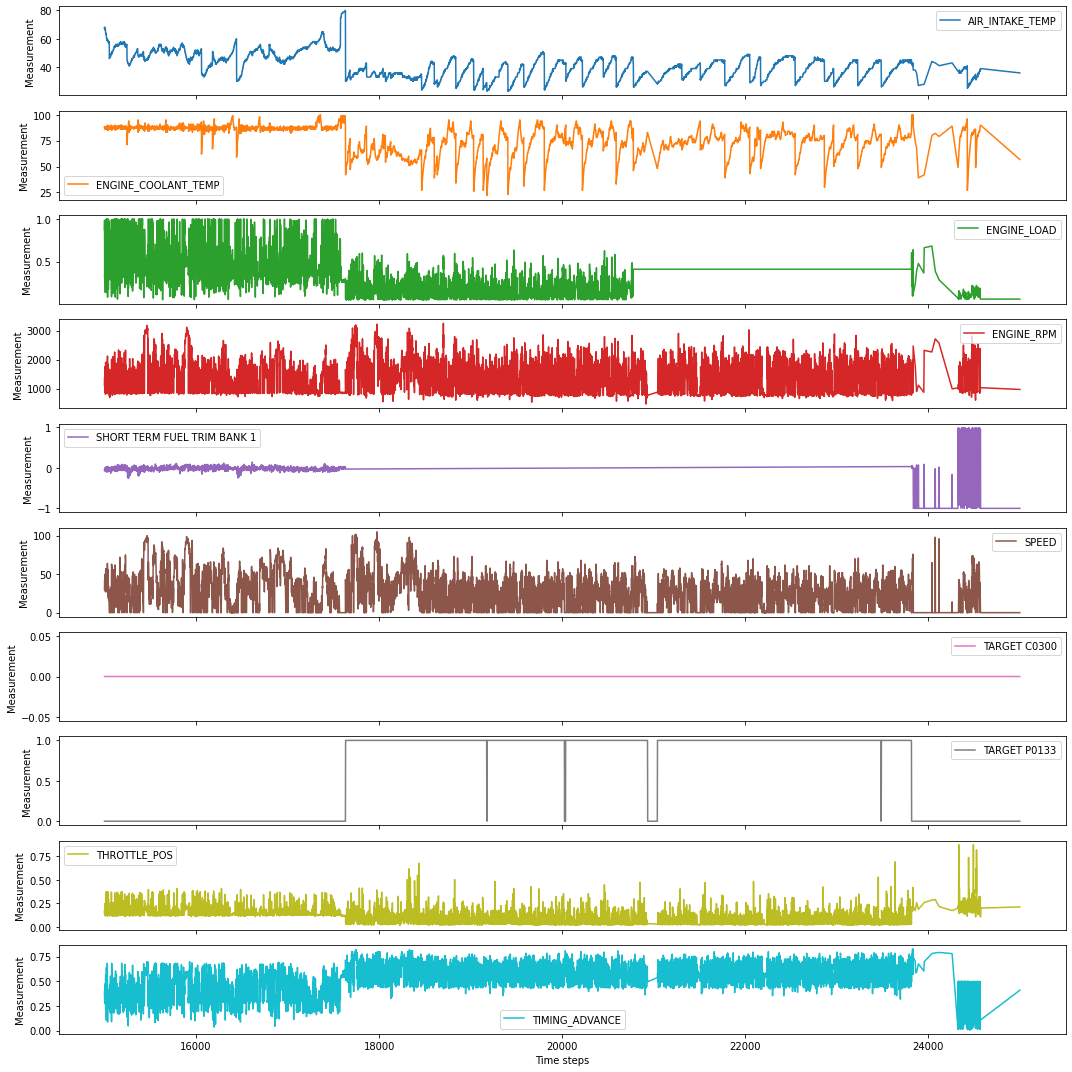

In [65]:
selected_columns = df.columns.difference(["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP", "TROUBLE_CODES_BINARY"])

df[selected_columns][15000:25000].plot(
    subplots=True, 
    figsize=(15, 15), 
    xlabel='Time steps', 
    ylabel='Measurement'
)

plt.tight_layout()
plt.show()

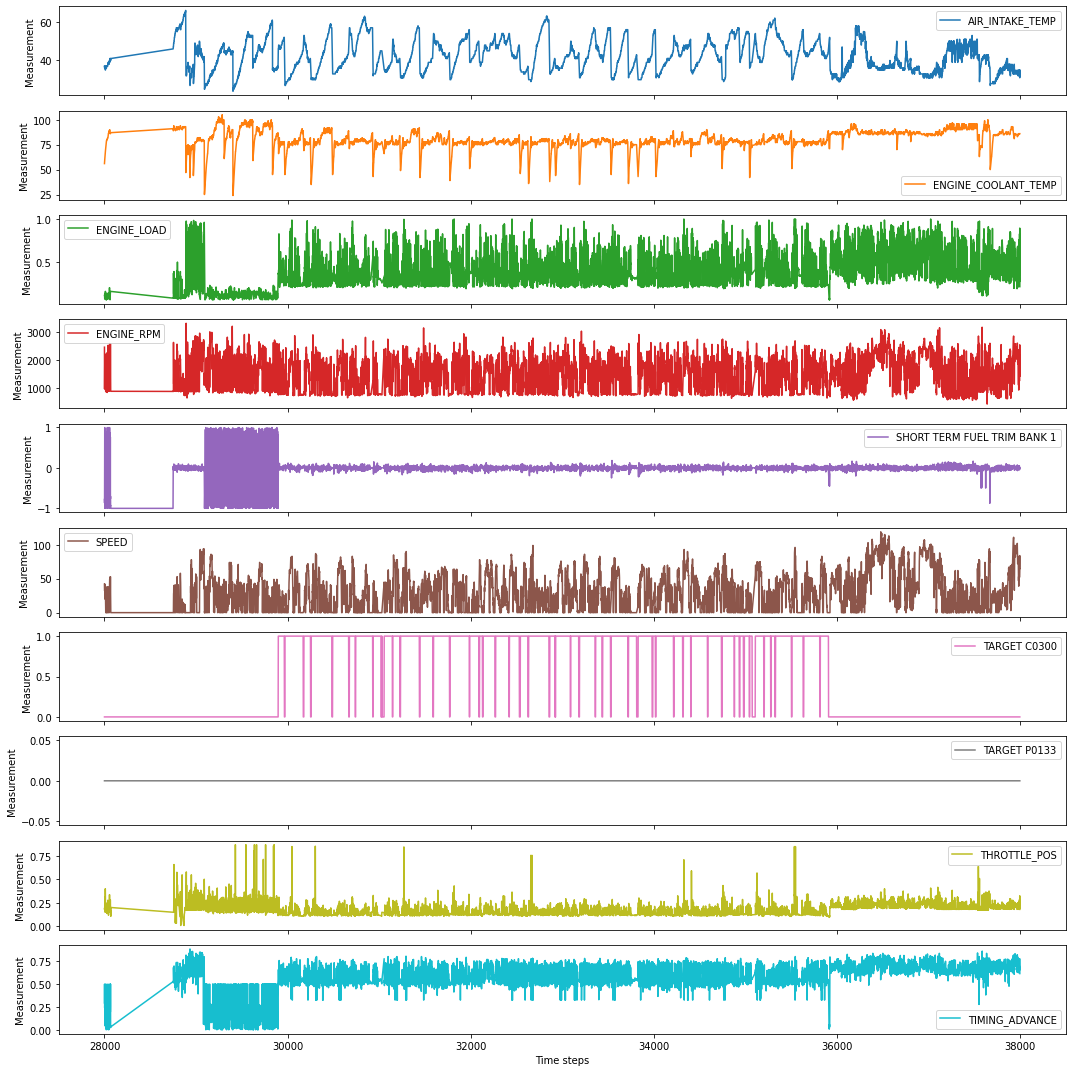

In [64]:
selected_columns = df.columns.difference(["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP", "TROUBLE_CODES_BINARY"])

df[selected_columns][28000:38000].plot(
    subplots=True, 
    figsize=(15, 15), 
    xlabel='Time steps', 
    ylabel='Measurement'
)

plt.tight_layout()
plt.show()

<Figure size 1080x432 with 0 Axes>

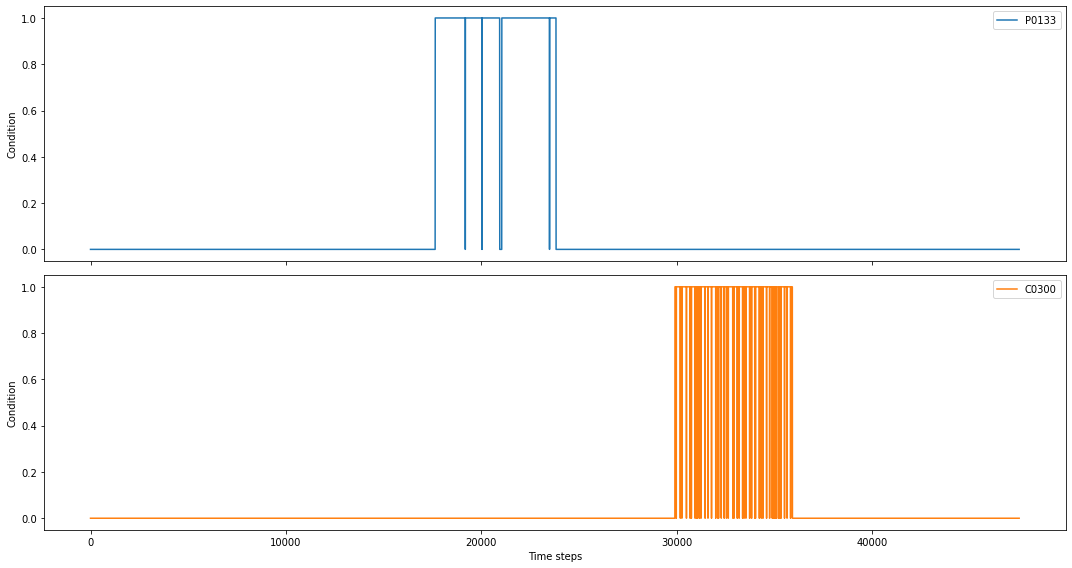

In [33]:
df_dtc = pd.DataFrame()

df_dtc["P0133"] = np.where(df["TROUBLE_CODES"] == "P0133", 1, 0) 
df_dtc["C0300"] = np.where(df["TROUBLE_CODES"] == "C0300", 1, 0)

plt_1 = plt.figure(figsize=(15, 6))

# plt.plot(list(range(0, len(xp))), xp, label="P0133")
# plt.plot(list(range(0, len(xc))), xc, label="C0300")

# plt.legend()

df_dtc.plot(subplots=True, 
             figsize=(15, 8), 
             xlabel='Time steps', 
             ylabel='Condition')

plt.tight_layout()
plt.show()


In [73]:
result = {
    "P0079": 0,
    "P0078": 0,
    "P007E": 0,
    "P007F": 0
}

counts = df[df["VEHICLE_ID"] == "car13"]["TROUBLE_CODES"].value_counts()

for k in result.keys():
    for m in counts.keys():
        if k in m:
            result[k] += counts[m]

result

{'P0079': 83, 'P0078': 41, 'P007E': 47, 'P007F': 11}

In [87]:
df_car13 = df[df["VEHICLE_ID"] == "car13"]

df_car13["TROUBLE_CODES"] = df_car13["TROUBLE_CODES"].fillna("0")

dtc_list = ["P0079", "P0078", "P007E", "P007F"] 

for dtc_code in dtc_list:
    df_car13.loc[df_car13["TROUBLE_CODES"].str.contains(dtc_code, case=False), 'TROUBLE_CODES'] = dtc_code

df_car13 = df_car13.reset_index(drop=True)
df_car13 = df_car13.fillna(0)

df_dummies = pd.get_dummies(df_car13["TROUBLE_CODES"], drop_first=True)
df_car13 = pd.concat([df_car13, df_dummies], axis=1)
selected_columns = df_car13.columns.difference(["VEHICLE_ID", "TIMESTAMP", 
                                                "TROUBLE_CODES_BINARY", "TARGET P0133", 
                                                "TARGET C0300", "TROUBLE_CODES"])
df_car13 = df_car13[selected_columns]
df_car13.head()

,AIR_INTAKE_TEMP,ENGINE_COOLANT_TEMP,ENGINE_LOAD,ENGINE_RPM,P0078,P0079,P007E,P007F,SHORT TERM FUEL TRIM BANK 1,SPEED,THROTTLE_POS,TIMING_ADVANCE
0,43.0,90.666667,0.294,744.5,0,0,0,0,0.0000,0.0,0.1410,0.478
1,43.0,90.333333,0.310,740.0,0,0,0,0,-0.0080,0.0,0.1490,0.467
2,43.0,90.000000,0.302,755.0,0,0,0,0,-0.0096,0.0,0.1466,0.478
3,43.0,89.666667,0.310,739.0,0,0,0,0,-0.0112,0.0,0.1442,0.482
4,43.0,89.333333,0.310,761.0,0,0,0,0,-0.0128,0.0,0.1418,0.459


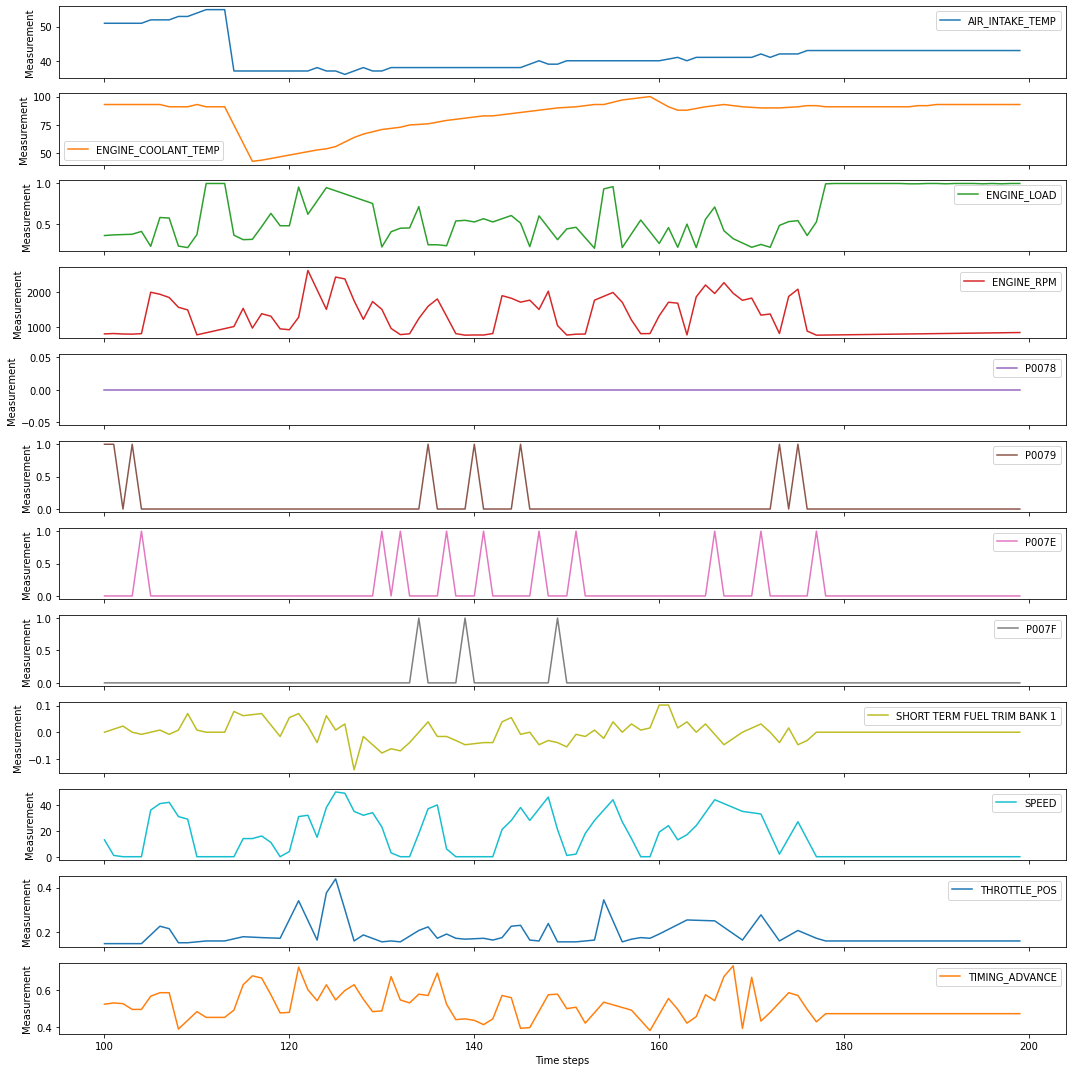

In [102]:
i = 100
df_car13[i:i+100].plot(subplots=True, 
              figsize=(15, 15), 
              xlabel='Time steps', 
              ylabel='Measurement'
             )
plt.tight_layout()
plt.show()

In [103]:
import plotly.graph_objects as go

In [110]:
fig = go.Figure()

# fig.add_trace(go.Scatter(x=list(df_car13.index), y=list(df_car13["P007E"]), name="P007E"))

# fig.add_trace(go.Scatter(x=list(df_car13.index), y=list(df_car13["P007F"]), name="P007F"))

# fig.add_trace(go.Scatter(x=list(df_car13.index), y=list(df_car13["P0078"]), name="P0078"))

fig.add_trace(go.Scatter(x=list(df_car13.index), y=list(df_car13["P0079"]), name="P0079"))

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [122]:
df_car13.P0079.sum()/len(df_car13)

0.04029126213592233

In [91]:
df_car13.to_csv("../data/odb-2-master-thesis/car13-preprocessed.csv")

In [99]:
len(df_car13) - 100 + 1

1961

In [ ]:
selected_columns = df.columns.difference(["TROUBLE_CODES", "VEHICLE_ID", "TIMESTAMP"])
df = df[selected_columns]

TARGET = "TROUBLE_CODES_BINARY"

X = df.drop([TARGET], axis=1)
y = df[TARGET]

X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

index_train = X_train.index
index_test = X_test.index

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, index=index_train, columns=X.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, index=index_test, columns=X.columns)

### Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=SEED)
log_reg.fit(X_train, y_train)

y_pred = lin_svc.predict(X_test)

print("Classification Report for the LinearSVC model \n")
print(classification_report(y_test, y_pred))

### Linear Support Vector Classifier

In [ ]:
lin_svc = LinearSVC(random_state=SEED)
lin_svc.fit(X_train, y_train)

y_pred = lin_svc.predict(X_test)

print("Classification Report for the LinearSVC model \n")
print(classification_report(y_test, y_pred))

### Random Forest Classifier

In [ ]:
# Model training
random_forest = RandomForestClassifier(random_state=SEED)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

print("Classification Report for the RandomForestClassifier model \n")
print(classification_report(y_test, y_pred))

## Time Series Classification on (3D) Panel Data

In [2]:
features_all = pd.read_parquet("../data/odb-2-window-89/features-all-windowsize89.parquet.gzip")
target_all = pd.read_parquet("../data/odb-2-window-89/target-binary-all-windowsize89.parquet.gzip")

In [3]:
features_all = features_all.set_index(["INSTANCES", "TIMEPOINTS"])
features_all.head()

AIR_INTAKE_TEMP  ENGINE_COOLANT_TEMP  ENGINE_LOAD  \
INSTANCES TIMEPOINTS                                                      
0         0                      59.0                 80.0        0.333   
          1                      59.0                 80.0        0.325   
          2                      59.0                 80.0        0.329   
          3                      60.0                 80.0        0.325   
          4                      60.0                 80.0        0.329   

                      ENGINE_RPM  SHORT TERM FUEL TRIM BANK 1  SPEED  \
INSTANCES TIMEPOINTS                                                   
0         0               1009.0                          0.0    0.0   
          1               1003.0                          0.0    0.0   
          2                995.0                          0.0    0.0   
          3               1004.0                          0.0    0.0   
          4               1005.0                          0.0    0.0   

                      THROTTLE_POS  TIMING_ADVANCE  
INSTANCES TIMEPOINTS                                
0         0                  0.251           0.569  
          1                  0.251           0.565  
          2                  0.251           0.573  
          3                  0.251           0.565  
          4                  0.251           0.569

In [4]:
# Create indices
index_train, index_test = train_test_split(features_all.index.levels[0], 
                                           test_size=0.20, 
                                           random_state=42)

In [5]:
# Split train and test
X_train = features_all.loc[index_train]
X_train = from_multi_index_to_3d_numpy(X_train)

y_train = target_all.loc[index_train]
y_train = y_train.values.flatten()

X_test = features_all.loc[index_test]
X_test = from_multi_index_to_3d_numpy(X_test)

y_test = target_all.loc[index_test]
y_test = y_test.values.flatten()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37003, 8, 89), (9251, 8, 89), (37003,), (9251,))

### MiniRocket transformation for the ODB-II DTC dataset + RidgeClassifierCV

In [6]:
%%time

minirocket_multi = MiniRocketMultivariate()
minirocket_multi.fit(X_train)

X_train_transform = minirocket_multi.transform(X_train)

CPU times: user 1min 16s, sys: 717 ms, total: 1min 16s
Wall time: 1min 16s


In [ ]:
%%time 

ridge = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
ridge.fit(X_train_transform, y_train)

<span style="color:red">MemoryError:</span> Unable to allocate 2.76 GiB for an array with shape (37003, 9996) and data type float64

### MiniRocket transformation for the ODB-II DTC dataset + LogisticRegression

In [50]:
%%time

log_reg = LogisticRegression(random_state=SEED)
log_reg.fit(X_train_transform, y_train)

<span style="color:red">MemoryError:</span> Unable to allocate 2.76 GiB for an array with shape (37003, 9996) and data type float64

### MiniRocket transformation for the ODB-II DTC dataset + LinearDiscriminantAnalysis

In [9]:
X_train_transform.describe()

,0,1,2,3,4,5,6,7,8,9,...,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995
count,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,...,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000,37003.000000
mean,0.337251,0.732872,0.203443,0.632689,0.771703,0.309111,0.700150,0.123272,0.580193,0.736650,...,0.669026,0.035240,0.244494,0.930114,0.229568,0.570288,0.851488,0.100397,0.995622,0.008432
std,0.178903,0.146579,0.114650,0.196691,0.129835,0.164021,0.162045,0.077412,0.221398,0.144890,...,0.059347,0.184389,0.429792,0.254959,0.095995,0.059311,0.113564,0.300533,0.066023,0.091438
min,0.033708,0.426966,0.022472,0.044944,0.483146,0.033708,0.404494,0.000000,0.033708,0.426966,...,0.370787,0.000000,0.000000,0.000000,0.000000,0.325843,0.483146,0.000000,0.000000,0.000000
25%,0.044944,0.617977,0.044944,0.494382,0.662921,0.044944,0.573034,0.044944,0.471910,0.617977,...,0.629214,0.000000,0.000000,1.000000,0.134831,0.516854,0.775281,0.000000,1.000000,0.000000
50%,0.426966,0.685393,0.224719,0.539326,0.741573,0.382022,0.640449,0.112360,0.505618,0.685393,...,0.629214,0.000000,0.000000,1.000000,0.224719,0.573034,0.853933,0.000000,1.000000,0.000000
75%,0.460674,0.955056,0.292135,0.955056,0.955056,0.426966,0.955056,0.179775,0.584270,0.955056,...,0.752809,0.000000,0.000000,1.000000,0.292135,0.629214,0.955056,0.000000,1.000000,0.000000
max,0.764045,0.977528,0.685393,0.977528,0.988764,0.752809,0.977528,0.449438,0.955056,0.977528,...,0.876405,1.000000,1.000000,1.000000,0.505618,0.797753,1.000000,1.000000,1.000000,1.000000


In [12]:
%%time 

lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
lda.fit(X_train_transform, y_train)

CPU times: user 1h 7min 13s, sys: 13min 48s, total: 1h 21min 2s
Wall time: 12min 19s


LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

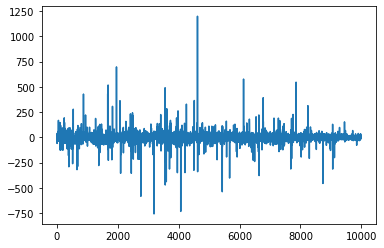

In [22]:
plt.plot(X_train_transform.columns, lda.coef_[0])
plt.show()

# pd.DataFrame(lda.coef_[0]).describe()


In [23]:
%%time 

X_test_transform = minirocket_multi.transform(X_test)

CPU times: user 18 s, sys: 117 ms, total: 18.1 s
Wall time: 18.1 s


In [25]:
%%time 

y_pred = lda.predict(X_test_transform)

CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 129 ms


In [37]:
%%time
print("Classification Report for the LinearDiscriminantAnalysis model \n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report for the LinearDiscriminantAnalysis model 

              precision    recall  f1-score   support

           0     0.9959    0.9958    0.9959      6886
           1     0.9877    0.9882    0.9880      2365

    accuracy                         0.9938      9251
   macro avg     0.9918    0.9920    0.9919      9251
weighted avg     0.9938    0.9938    0.9938      9251

CPU times: user 16 ms, sys: 1.21 ms, total: 17.2 ms
Wall time: 14.8 ms


In [36]:
print("F1 binary:", f1_score(y_test, y_pred))
print("F1 micro:", f1_score(y_test, y_pred, average="micro"))
print("F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred, average="weighted"))

F1 binary: 0.9879518072289156
F1 micro: 0.9938385039455194
F1 macro: 0.9919063371341732
F1 weighted: 0.9938389314160527


## MiniRocket transformation for the ODB-II DTC dataset + SVM (LinearSVC)

In [ ]:
# %%time

# lin_svc = LinearSVC()
# lin_svc.fit(X_train_transform, y_train)

<span style="color:red">MemoryError:</span> Unable to allocate 2.76 GiB for an array with shape (37003, 9996) and data type float64

### MiniRocket transformation for the ODB-II DTC dataset + RandomForestClassifier

In [42]:
%%time 

# Model training
random_forest = RandomForestClassifier(random_state=SEED)
random_forest.fit(X_train_transform, y_train)

CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


RandomForestClassifier(random_state=42)

In [43]:
%%time 

y_pred = random_forest.predict(X_test_transform)

CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.3 s


In [45]:
%%time 

print("Classification Report for the RandomForestClassifier model \n")
print(classification_report(y_test, y_pred, digits=4))

Classification Report for the RandomForestClassifier model 

              precision    recall  f1-score   support

           0     0.9959    0.9951    0.9955      6886
           1     0.9857    0.9882    0.9869      2365

    accuracy                         0.9933      9251
   macro avg     0.9908    0.9916    0.9912      9251
weighted avg     0.9933    0.9933    0.9933      9251

CPU times: user 17.7 ms, sys: 197 µs, total: 17.9 ms
Wall time: 14.7 ms


In [47]:
print("F1 binary:", f1_score(y_test, y_pred))
print("F1 micro:", f1_score(y_test, y_pred, average="micro"))
print("F1 macro:", f1_score(y_test, y_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_pred, average="weighted"))

F1 binary: 0.9869087837837838
F1 micro: 0.9932980218354772
F1 macro: 0.9912024668592027
F1 weighted: 0.9933008066261434


### Supervised Time Series Forest Classifier

In [ ]:
%%time 

# sts_forest = SupervisedTimeSeriesForest(n_estimators=10)
# sts_forest.fit(X_train, y_train)

ValueError: Data seen by SupervisedTimeSeriesForest instance has multivariate series, but this SupervisedTimeSeriesForest instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.

In [ ]:
# y_pred = clf.predict(X_test)

# print("Classification Report for the SupervisedTimeSeriesForest model \n")
# print(classification_report(y_test.values.flatten(), y_pred.values.flatten()))

### Mcfly AutoML

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
X_train = np.swapaxes(X_train, 1, 2)
X_val = np.swapaxes(X_val, 1, 2)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train)

In [ ]:
y_train

In [ ]:
%%time

best_model, best_params, best_model_type, knn_acc = \
            find_best_architecture(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val, 
                number_of_models=10,
                nr_epochs=20,
                # subset_size=5000,
            )

```
Training model 9 ResNet
Epoch 1/20
5/5 [==============================] - 20s 4s/step - loss: 0.0000e+00 - accuracy: 0.2900 - val_loss: 0.0000e+00 - val_accuracy: 0.2531
Epoch 2/20
5/5 [==============================] - 16s 4s/step - loss: 0.0000e+00 - accuracy: 0.2900 - val_loss: 0.0000e+00 - val_accuracy: 0.2531
Epoch 3/20
5/5 [==============================] - 15s 4s/step - loss: 0.0000e+00 - accuracy: 0.2900 - val_loss: 0.0000e+00 - val_accuracy: 0.2531
Epoch 3: early stopping
Best model: model  0
Model type:  InceptionTime
Hyperparameters:  {'learning_rate': 0.00987769396837994, 'regularization_rate': 0.0009260936235962637, 'network_depth': 6, 'filters_number': 79, 'max_kernel_size': 71}
accuracy on validation set:  0.25307390093803406
Accuracy of kNN on validation set 0.7289555465477638
CPU times: user 1h 55min 49s, sys: 28min 50s, total: 2h 24min 40s
Wall time: 30min 29s
```

In [ ]:
history = best_model.fit(
    X_train, 
    y_train,
    epochs=3, 
    validation_data=(X_val, y_val)
)